In [4]:

# STEP 1: import libries and dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load Final Preprocessed Dataset
final_path = '/content/drive/My Drive/results/final_preprocessed_dataset.csv'
final_df = pd.read_csv(final_path)
print("Loaded final preprocessed dataset:", final_df.shape)

Mounted at /content/drive
Loaded final preprocessed dataset: (6295, 11)


In [5]:

# STEP 2: Split Dataset into Train and Test


# Separate features and target
X = final_df.drop(columns=["Target"])
y = final_df["Target"]

# 80% Train - 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, "Testing set:", X_test.shape)


Training set: (5036, 10) Testing set: (1259, 10)


In [6]:

# STEP 3: Feature Scaling


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:

# STEP 4: Define Base Logistic Regression Model & Hyperparameter Grid


log_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')

param_grid = {
    'C': [0.01, 0.1, 1, 10],   # Regularization strength
    'penalty': ['l2'],         # L1 or L2 possible (l1 requires solver='liblinear')
    'solver': ['lbfgs', 'saga'] # Solvers for multinomial
}


In [8]:

# STEP 5: GridSearchCV for Logistic Regression


grid_search_log = GridSearchCV(
    estimator=log_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_log.fit(X_train_scaled, y_train)
print("\nBest Parameters Found:", grid_search_log.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters Found: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [9]:

# STEP 6: Evaluate Logistic Regression Model


best_log = grid_search_log.best_estimator_

# Predict
y_pred_log = best_log.predict(X_test_scaled)
accuracy_log = accuracy_score(y_test, y_pred_log)

# Map class names if needed
class_labels = ['Dropout', 'Graduate', 'Enrolled']

if y_test.dtype != 'O':
    y_test_named = y_test.map({0:'Dropout',1:'Graduate',2:'Enrolled'})
    y_pred_named = pd.Series(y_pred_log).map({0:'Dropout',1:'Graduate',2:'Enrolled'})
else:
    y_test_named = y_test
    y_pred_named = pd.Series(y_pred_log)

print("\n🎯 Test Accuracy:", round(accuracy_log,4))
print("\n📊 Classification Report:")
print(classification_report(y_test_named, y_pred_named, target_names=class_labels))

# Confusion Matrix
cm_log = confusion_matrix(y_test_named, y_pred_named)
cm_df_log = pd.DataFrame(cm_log, index=class_labels, columns=class_labels)
print("\nConfusion Matrix:")
display(cm_df_log)



🎯 Test Accuracy: 0.7585

📊 Classification Report:
              precision    recall  f1-score   support

     Dropout       0.82      0.75      0.79       411
    Graduate       0.77      0.83      0.80       417
    Enrolled       0.69      0.70      0.70       431

    accuracy                           0.76      1259
   macro avg       0.76      0.76      0.76      1259
weighted avg       0.76      0.76      0.76      1259


Confusion Matrix:


,Dropout,Graduate,Enrolled
Dropout,309,31,71
Graduate,10,346,61
Enrolled,57,74,300


In [10]:

# STEP 7: 5-Fold Cross-Validation Accuracy


cv_scores_log = cross_val_score(best_log, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\n5-Fold CV Accuracy: {:.4f} ± {:.4f}".format(cv_scores_log.mean(), cv_scores_log.std()))



5-Fold CV Accuracy: 0.7367 ± 0.0081


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

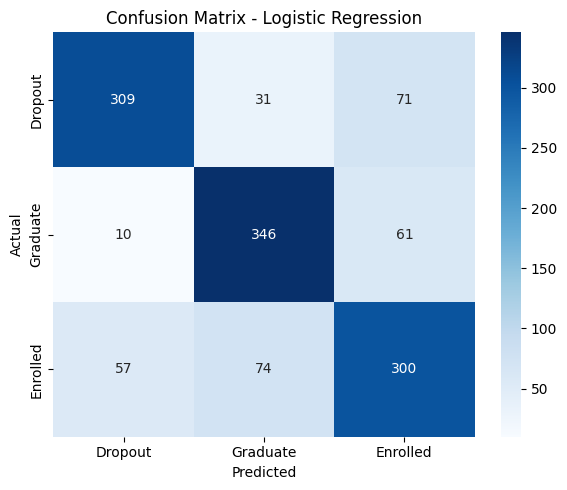

In [11]:

# STEP 8: Logistic Regression Visualizations


# Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/results/logreg_confusion_matrix.png', bbox_inches='tight')
plt.show()

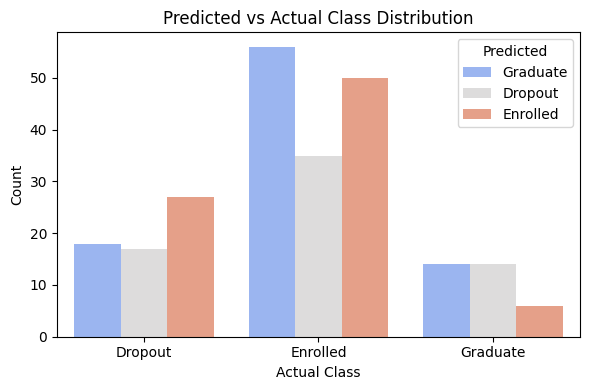

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_test_named, hue=y_pred_named, palette='coolwarm')
plt.title('Predicted vs Actual Class Distribution')
plt.xlabel('Actual Class')
plt.ylabel('Count')
plt.legend(title='Predicted')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/results/logreg_pred_vs_actual.png', bbox_inches='tight')
plt.show()

In [14]:

# STEP 9: Save Logistic Regression Performance


results_summary_log = {
    "Best Parameters": [grid_search_log.best_params_],
    "Test Accuracy": [accuracy_log],
    "CV Mean Accuracy": [cv_scores_log.mean()],
    "CV Std Dev": [cv_scores_log.std()]
}

results_df_log = pd.DataFrame(results_summary_log)
results_df_log.to_csv('/content/drive/My Drive/results/logreg_results_summary.csv', index=False)
print("\nLogistic Regression results saved to: /content/drive/My Drive/results/logreg_results_summary.csv")



Logistic Regression results saved to: /content/drive/My Drive/results/logreg_results_summary.csv
